make Robinson Projection  
using map_templateb_table.html 

In [1]:
from collections import defaultdict
import vmapper
import os
import numpy as np
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.ops import transform, split
import shapely
from pyproj import Transformer, CRS, Proj

import matplotlib.pyplot as plt
import seaborn as sns

from catppuccin_palette import catppuccin as cpc
import mplcatppuccin
from mplcatppuccin.palette import load_color
from mplcatppuccin.colormaps import get_colormap_from_list
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
#from jinja2 import Environment, PackageLoader, select_autoescape
import jinja2
from tqdm.notebook import tqdm

/home/benny/.pyenv/versions/anaconda3-2022.10/lib/python3.9/site-packages/geopandas/geodataframe.py:1805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[exploded_geom.name] = exploded_geom.values
/tmp/ipykernel_356143/2728975135.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf3['area'] = gdf3.area


<Axes: >

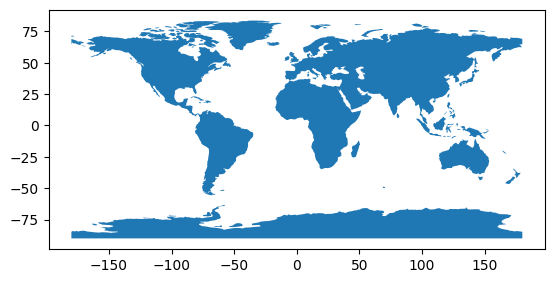

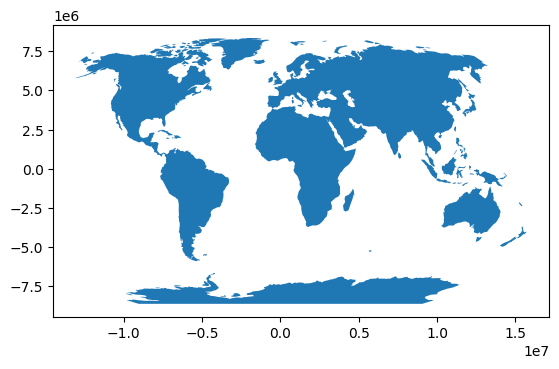

In [3]:
fp = '../data/natural_earth/ne_110m_admin_0_countries2.shp'
#fp = 'data/natural_earth/ne_110m_land.shp'
gdf = gpd.read_file(fp)
gdf2 = gdf.dissolve().explode(index_parts=True)
gdf3 = gdf2[['featurecla', 'geometry']].copy()
gdf3['area'] = gdf3.area
gdf4 = gdf3[gdf3['area']>1]
gdf4 = gdf4.reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
gdf4.plot()
#gdf.plot()
this_crs = '+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
gdf4.to_crs(this_crs).plot()

<Axes: >

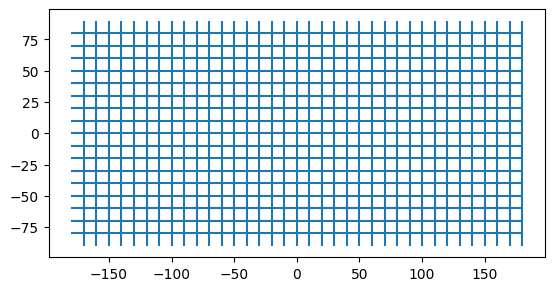

In [173]:
fp = '../data/natural_earth/ne_110m_graticules_10.shp'
grid = gpd.read_file(fp)
grid['display0'] = [d.replace(' ', '') for d in grid['display']]

grid.plot()

In [174]:
grid.head()

,degrees,direction,display,scalerank,dd,geometry,display0
0,80,N,80 N,4,80,"LINESTRING (180.00000 79.99848, 179.99664 79.9...",80N
1,70,N,70 N,4,70,"LINESTRING (180.00000 69.99847, 179.99664 69.9...",70N
2,60,N,60 N,4,60,"LINESTRING (180.00000 59.99866, 179.99664 59.9...",60N
3,50,N,50 N,4,50,"LINESTRING (179.99990 49.99876, 179.99664 49.9...",50N
4,40,N,40 N,4,40,"LINESTRING (179.99990 39.99875, 179.99664 39.9...",40N


In [175]:
gdf4.head()

,id,featurecla,geometry,area
0,0,Admin-0 country,"POLYGON ((-163.71290 -78.59567, -163.71290 -78...",3.716703
1,1,Admin-0 country,"POLYGON ((-122.40624 -73.32462, -121.21151 -73...",1.541898
2,2,Admin-0 country,"POLYGON ((-100.78346 -72.50162, -101.80187 -72...",3.004556
3,3,Admin-0 country,"POLYGON ((-78.18210 8.31918, -78.43547 8.38771...",4158.334445
4,4,Admin-0 country,"POLYGON ((-128.35841 50.77065, -127.30858 50.5...",4.056773


In [311]:
tmp = gdf4.copy()
tmp2 = tmp[tmp['id']==44].copy()
tmp2

,id,featurecla,geometry,area
44,44,Admin-0 country,"POLYGON ((130.00000 -90.00000, 125.00000 -90.0...",5982.564063


In [357]:
y = -100
x1 = (120-180)+0.5  # right
x2 = (120-180)-0.5  # left
x3 = 120-180
print(x1, x2, x3)
ys = []
line1 = []
line2 = []
line3 = []
for i in range(1, 40):
    # go north
    y = y + 5
    line1.append((x1, y))
    line2.append((x2, y))
    line3.append((x3, y))
    ys.append(y)

print(ys)

-59.5 -60.5 -60
[-95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


-59.9 -60.1 -60


<Axes: >

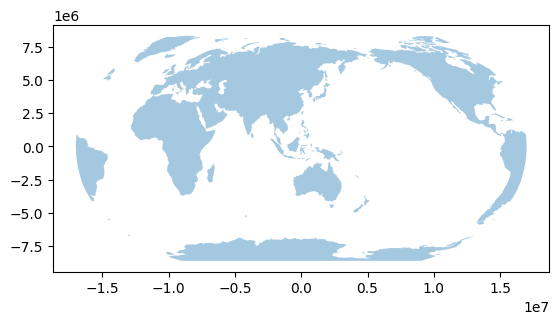

In [359]:
y = -100
x1 = (120-180)+0.1  # right
x2 = (120-180)-0.1  # left
x3 = 120-180
print(x1, x2, x3)

line1 = []
line2 = []
line3 = []
for i in range(1, 40):
    # go north
    y = y + 5
    line1.append((x1, y))
    line2.append((x2, y))
    line3.append((x3, y))

line1 = LineString(line1)
line2 = LineString(line2)
line3 = LineString(line3)


tmp = gdf4.copy()
#tmp2 = tmp[tmp['id']==44].copy()
geoms = []
for poly in tmp.geometry:
    split_polys = split(poly, line1)
    split_polys = [p for p in split_polys.geoms]
    if len(split_polys)==1:
        gs = split_polys
        new_poly = Polygon(gs[0])
    else:
        #print(len(split_polys))
        gs = []
        for p in split_polys:
            tmp3 = split(p, line2)
            tmp3 = [p for p in tmp3.geoms]
            #print(len(tmp3))
            gs.extend(tmp3)
        gs2 = []
        for g in gs:
            if not(g.intersects(line3)):
                gs2.append(g)
        #print(len(gs), len(gs2))
        new_poly = MultiPolygon(gs2)
    geoms.append(new_poly)
tmp['geometry'] = geoms

this_crs = '+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
tmp2 = tmp.explode(index_parts=False)
tmp2b = tmp2.to_crs(this_crs)
tmp2b.plot(alpha=.4)
#tmp2c = tmp2b[[~shapely.is_ccw(g) for g in tmp2b.geometry]]
#tmp2c.plot(alpha=.4)

In [355]:
#tmp2[tmp2.is_simple], len(tmp2)

<Axes: >

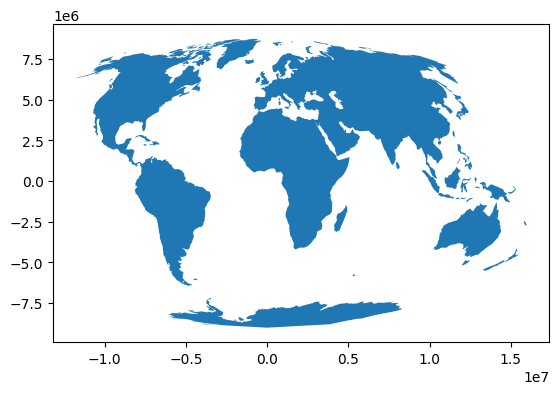

In [209]:
gdf4.to_crs('ESRI:54009').plot()

<Axes: >

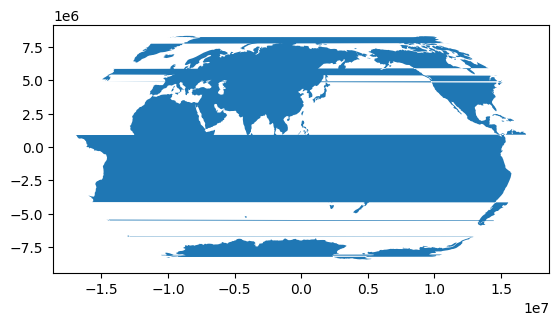

In [205]:

this_crs = '+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' # robinson
gdf4.to_crs(this_crs).plot()

<Axes: >

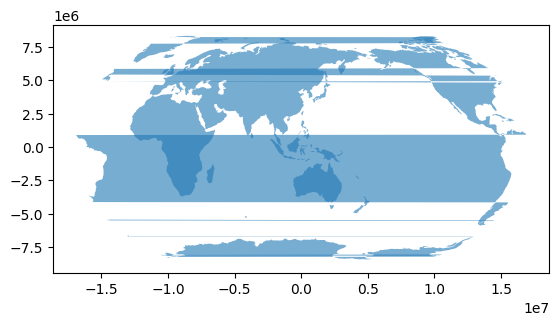

In [224]:

tmp = gdf4.to_crs(this_crs)
tmp2 = tmp#[~tmp['geometry'].is_simple]
#tmp2 = tmp['geometry'].make_valid()
tmp2.plot(alpha=.6)

    id       featurecla                                           geometry   
0    0  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...  \
1    1  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
2    2  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
3    3  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
4    4  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
..  ..              ...                                                ...   
87  87  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
88  88  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
89  89  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
90  90  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   
91  91  Admin-0 country  POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   

           area  
0      3.716703  
1      1.541898  
2      3.

<Axes: >

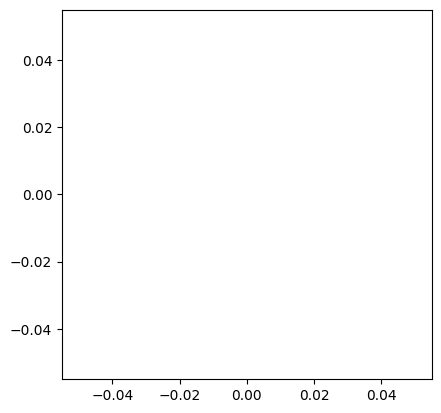

In [227]:
crs_proj = '+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
crs_wgs = "epsg:4326"

# define Transformer ahead of time
# with xy-order of coordinates
proj_transformer = Transformer.from_crs(crs_wgs, crs_proj, always_xy=True)

def project_geometry(geom):
    #print(geom)
    geom_proj = transform(proj_transformer.transform, geom)
    return geom_proj

tmp3 = gdf4.set_geometry(tmp2.geometry.apply(project_geometry))
print(tmp3)
tmp3.plot()


In [228]:
tmp2.geometry

0     POLYGON ((4584255.358 -7997533.830, 4584255.41...
1     POLYGON ((7656969.550 -7565749.653, 7716367.02...
2     POLYGON ((9163884.297 -7495001.807, 9119875.25...
3     POLYGON ((15237234.766 889752.531, 15212650.75...
4     POLYGON ((9103985.814 5406492.283, 9204083.800...
                            ...                        
87    POLYGON ((1701923.420 4548147.166, 1736763.143...
88    POLYGON ((1976534.433 4924550.202, 1905718.023...
89    POLYGON ((1347042.846 7603301.315, 1426155.278...
90    POLYGON ((1785169.613 7688872.864, 1657003.782...
91    POLYGON ((1343336.735 7798081.939, 1582240.977...
Name: geometry, Length: 92, dtype: geometry

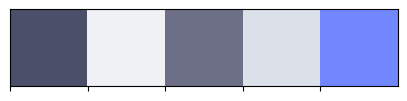

In [176]:
DARK = load_color('latte', 'text')
WHITE = load_color('latte', 'base')
LIGHTGRAY = load_color('latte', 'crust')
GRAY = load_color('latte', 'subtext0')
LINE = load_color('latte', 'lavender')
sns.palplot([DARK, WHITE, GRAY, LIGHTGRAY, LINE])

In [389]:
def generate_svg2(m, the_gdf, the_grid, title, vis):
    #m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})
    m.add_geodataframe(the_grid, layername='{}-grid'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='display0', idby='display2'),
        strokecolor=LINE, opacity=0.7,
        strokewidth=30000, showlabel=False, visibility=vis)
    m.add_geodataframe(the_gdf, layername='{}-land'.format(title.replace(' ', '_')), 
        draw_setting=dict(labelby='id', idby='id2'), 
        color=DARK, opacity=0.6, strokecolor=DARK, strokewidth=30, showlabel=False, 
        visibility=vis)
    #m.add_title(title+' Projection')

In [179]:

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    print(x)

0
30
60
90
120
150
180
-150
-120
-90
-60
-30


In [361]:
projections = {}

for x in [x*30 for x in range(12)]:
    if x>180:
        x-=180
        x = -180+x
    x2 = 'E{}'.format(x) if x>0 else 'W{}'.format(abs(x)) if x<0 else 'EW{}'.format(x)
    n = x2
    #print(n)
    this_crs = '+proj=robin +lon_0={} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs' .format(x)
    projections[n] = (this_crs, x)
    #print(this_crs)
    #gdf4.to_crs(this_crs).plot(fc='none', ec='k')
    #grid.to_crs(this_crs).plot(fc='none', ec='k')
len(projections)


12

In [362]:
projections

{'EW0': ('+proj=robin +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  0),
 'E30': ('+proj=robin +lon_0=30 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  30),
 'E60': ('+proj=robin +lon_0=60 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  60),
 'E90': ('+proj=robin +lon_0=90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  90),
 'E120': ('+proj=robin +lon_0=120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  120),
 'E150': ('+proj=robin +lon_0=150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  150),
 'E180': ('+proj=robin +lon_0=180 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  180),
 'W150': ('+proj=robin +lon_0=-150 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -150),
 'W120': ('+proj=robin +lon_0=-120 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -120),
 'W90': ('+proj=robin +lon_0=-90 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs',
  -90),
 'W60': ('+proj=robin

In [391]:
def split_globe(lon0, the_gdf):
    y = -100
    if lon0>=0:
        opposite = lon0 - 180
    else:
        opposite = lon0 + 180
    x1 = opposite+0.1  # right
    x2 = opposite-0.1  # left
    x3 = opposite # center
    #print(lon0, x3)
    #print(x1, x2, x3)

    line1 = []
    line2 = []
    line3 = []
    for i in range(1, 40):
        # go north
        y = y + 5
        line1.append((x1, y))
        line2.append((x2, y))
        line3.append((x3, y))

    line1 = LineString(line1)
    line2 = LineString(line2)
    line3 = LineString(line3)

    tmp = the_gdf.copy()
    geoms = []
    for poly in tmp.geometry:
        split_polys = split(poly, line1)
        split_polys = [p for p in split_polys.geoms]
        if len(split_polys)==1:
            gs = split_polys
            new_poly = Polygon(gs[0])
        else:
            #print(len(split_polys))
            gs = []
            for p in split_polys:
                tmp3 = split(p, line2)
                tmp3 = [p for p in tmp3.geoms]
                #print(len(tmp3))
                gs.extend(tmp3)
            gs2 = []
            for g in gs:
                if not(g.intersects(line3)):
                    gs2.append(g)
            #print(len(gs), len(gs2))
            new_poly = MultiPolygon(gs2)
        geoms.append(new_poly)
    tmp['geometry'] = geoms
    #tmp2 = tmp.explode(index_parts=False)
    return tmp

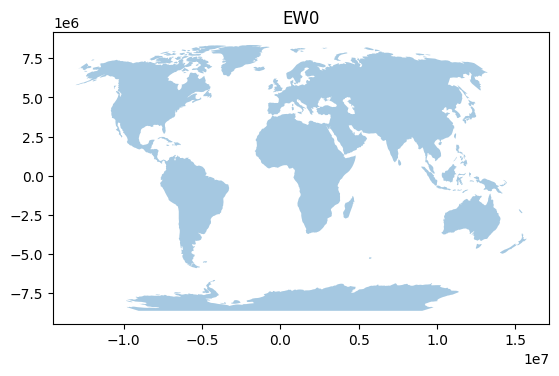

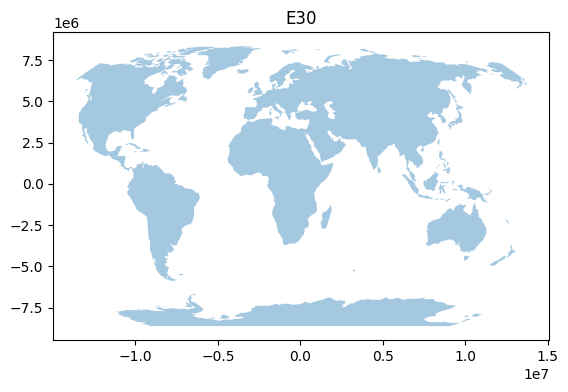

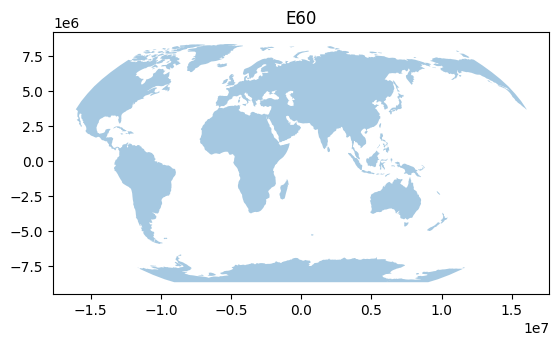

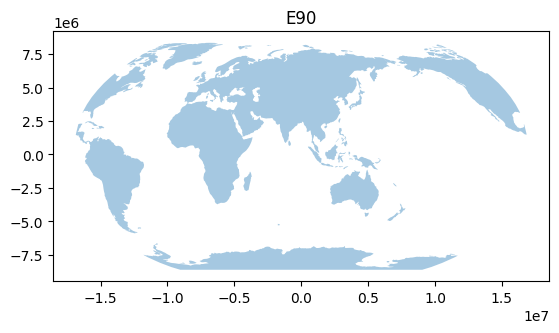

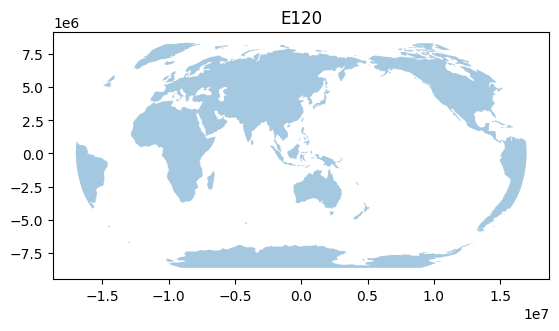

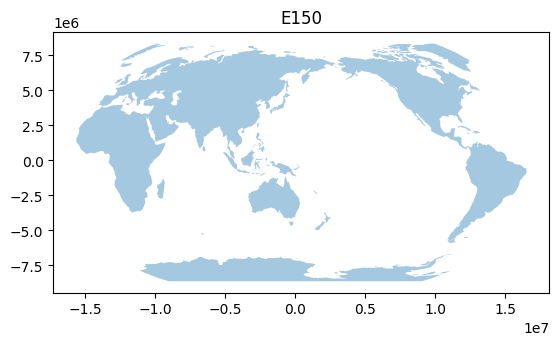

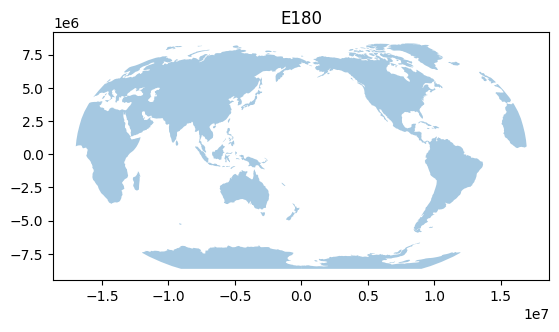

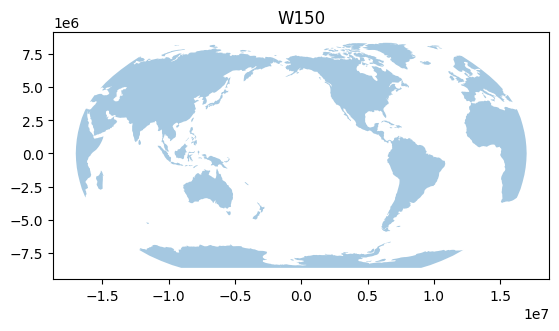

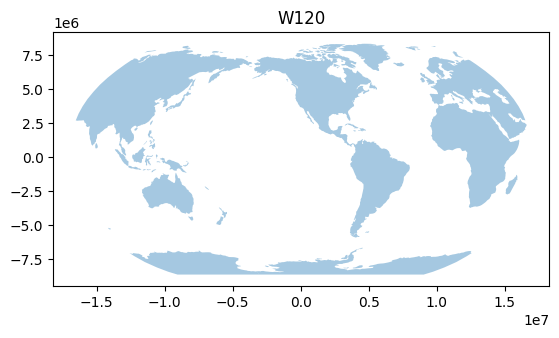

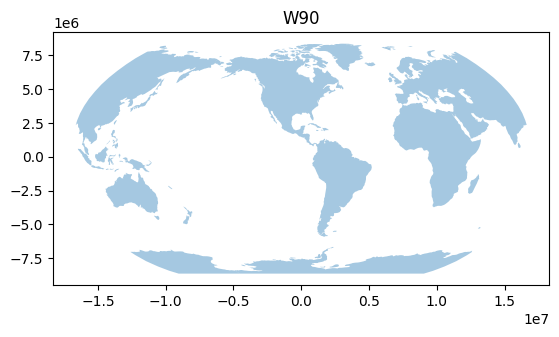

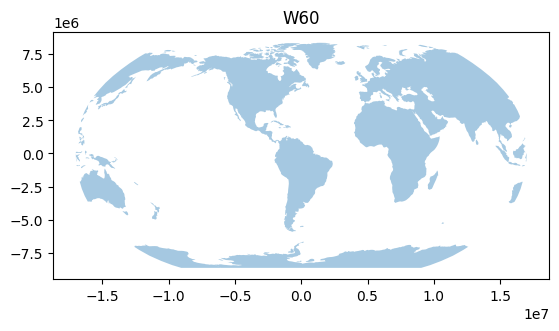

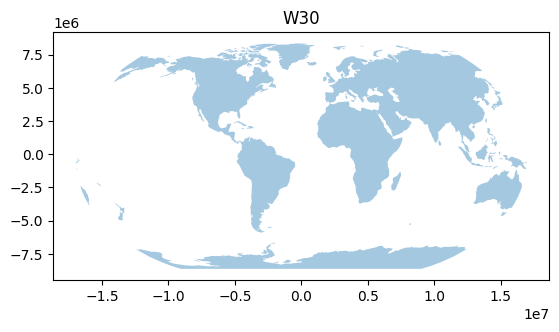

In [392]:

for k in projections:
    crs, lon0 = projections[k]
    the_grid = grid.to_crs(crs).copy()
    the_gdf = gdf4.copy() 
    the_gdf = split_globe(lon0, the_gdf)
    the_gdf = the_gdf.to_crs(crs).copy() 
    fig, ax = plt.subplots()
    the_gdf.plot(alpha=.4, ax=ax)
    ax.set_title(k)
    #break

In [399]:
m = vmapper.Map(interactive=False, params={'bgcolor': WHITE})


check = 0
proj_list = []
projections2 = {}
for k in projections:
    crs, lon0 = projections[k]
    projections2[k] = crs
    vis = 'hidden' if check>0 else 'visible'
    the_grid = grid.to_crs(crs).copy()
    the_gdf = gdf4
    the_gdf = split_globe(lon0, the_gdf).to_crs(crs)
    #the_gdf = check_geom(the_gdf, gdf4)
    k2 = k.replace(' ', '_')
    the_gdf['id2'] = ['{}-{}'.format(k2, i) for i in the_gdf['id']]
    the_grid['display2'] = ['{}-{}'.format(k2, i) for i in the_grid['display0']]
    #print(the_gdf)
    generate_svg2(m, the_gdf, the_grid, k, vis)
    proj_list.append(k)
    print(k)
    check+=1
    #if check==4:
    #    break


EW0
E30
E60
E90
E120
E150
E180
W150
W120
W90
W60
W30


In [394]:
svgText = m.make_scene()
#print(outputText)


In [400]:
temp_vars = {'first_title': proj_list[0], 
             'first_proj4': projections2[proj_list[0]],
             'content': svgText,
             'projections_collection': proj_list[1:],
             'projs': projections2,
}
temp_vars['first_title']

'EW0'

In [401]:
templateLoader = jinja2.FileSystemLoader( searchpath="." )
templateEnv = jinja2.Environment( loader=templateLoader )
TEMPLATE_FILE = "map_templateb_robin.html"

template = templateEnv.get_template( TEMPLATE_FILE )
outputText = template.render( temp_vars )

outputfn = 'test5.html'

with open(outputfn, 'wb') as f:
    f.write(outputText.encode("utf-8"))